In [ ]:
%%html
<style>table {float:left}</style>
<style>img {float:left}</style>

<hr style="height:1px;border:none;color:#333;background-color:#333;" />

**Task Description**

1. Organise the Denoising Autoencoder (DAE) project structure, get data and run the notebook.
2. Experiment with batch and epochs for model training.
3. Experiment with DAE optimisers and their parameters (e.g. SGD, RMSprop, Adam, Adamax, Nadam).
4. Change the DAE details / architecture
5. Report your experimental results.
6. Include performance results and charts for your experiment runs.
7. Save the IPYNB notebook, convert it to PDF (via HTML) and submit both for assessment.

<hr style="height:1px;border:none;color:#333;background-color:#333;" />

## Table of Content
   
1. [Notebook Preparation](#cell_Preparation)

2. [Data Preprocessing](#cell_Preprocessing)

3. [Model Construction](#cell_model)

4. [Model Execution](#cell_execution)
 
5. [Experiments Report](#cell_report)



<a id = "cell_Preparation"></a>
## 1. Notebook Preparation

*Provide code to load all required Python libraries (e.g. pandas, tensorflow, keras).*

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D,UpSampling2D, BatchNormalization, LeakyReLU,Conv2DTranspose, ReLU, MaxPool2D, Dropout,add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers

*Provide code to define any common functions (e.g. output format, plot, error calculations) that you will use below.*

In [2]:
#Function show images
def image_plot(img_count,data,plot_title):
  plt.figure(figsize=(15, 15))
  for i in range(img_count):  
    plt.subplot(5, 5, i+1)
    plt.subplots_adjust(wspace=0.5)
    plt.xticks([])
    plt.yticks([])
    plt.grid('off')
    plt.imshow(data[i])
    plt.suptitle(plot_title,y=1.01)
    plt.tight_layout()   

In [3]:
#Function to plot loss

def plot_loss(train_loss,val_loss):
  plt.figure(figsize=(10, 5))
  epochs = range(1, len(train_loss) + 1)
  plt.plot(epochs, train_loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'red')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [4]:
#Function to calculate MAE
def mae_images(images1, images2):
    return np.abs(np.subtract(images1, images2)).mean()

#Function to calculate mse
def mse_images(images1, images2):
    return np.square(np.subtract(images1, images2)).mean()

<a id = "cell_Preprocessing"></a>
## 2. Data Preprocessing

*Load data from file and carry out necessary preprocessing. Prepare the data for training and validation. We are working with CIFAR10 images in this assignment. Some code to load the data is provided below.*

In [5]:
from tensorflow.keras.datasets import cifar10

# Data parameters
img_rows, img_cols, img_ch = 32, 32, 3


# the data, shuffled and split between train and test sets
(x_train, _), (x_test, _) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print("Train images shape: {}\nTest images shape: {}".format((x_train.shape), (x_test.shape)))

170508288/170498071 [==============================] - 4s 0us/step
Train images shape: (50000, 32, 32, 3)
Test images shape: (10000, 32, 32, 3)


*Inject noise into all images (both training and testing). with noice factor = 0.3*

In [6]:
noise_factor = 0.3
noisy_x_train = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
noisy_x_test = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

noisy_x_train = np.clip(noisy_x_train, 0., 1.)
noisy_x_test = np.clip(noisy_x_test, 0., 1.)

*Plot original "clean" images and noisy images.*

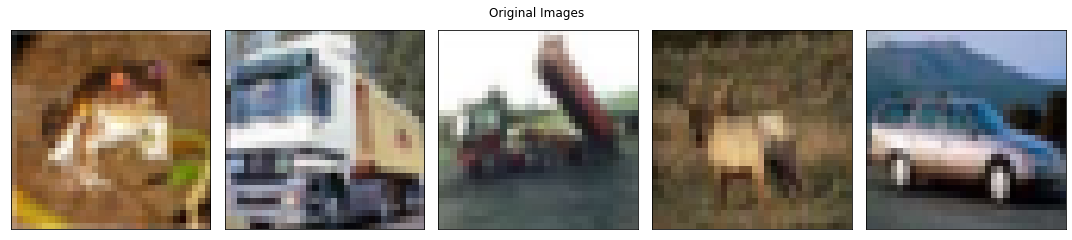

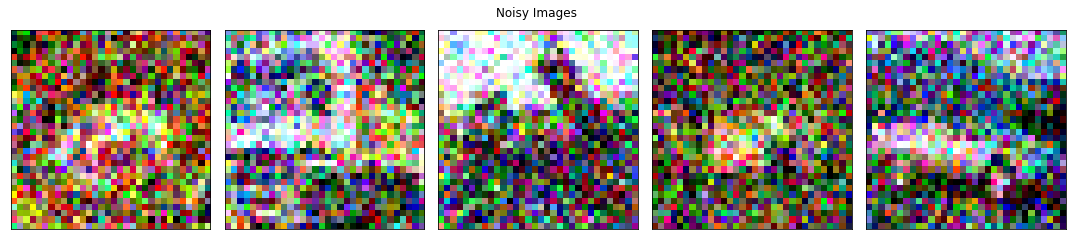

In [ ]:
#Showing original and noisy images
image_plot(5,x_train,"Original Images")
image_plot(5,noisy_x_train,"Noisy Images")

<a id = "cell_model"></a>
## 3. Model Construction

*Provide code to create your denoising autoencoder in this section. Create at least 2  models with varied settings (e.g. layers, types of layer,  number of nodes, activation functions, optimizers). Note: Your models should not be exactly the same as the models, which were already included in the weekly practical contents.*

*Once the models are defined, create executable models and visualize their architecture. Hint: use model.summary() function*.

In [8]:
#Defining input shape for input layer
input_shape = x_train.shape[1:]

#Callback
callback = EarlyStopping(monitor='val_loss', patience=10, verbose=0) 

In [51]:
#Model 1

input_img = Input(shape=input_shape)
x = Conv2D(128, (3, 3), padding='same',activation='relu')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), padding='same',activation='relu')(x)
x = BatchNormalization()(x)
encoder = MaxPooling2D((2, 2), padding='same')(x)


x = Conv2D(64, (3, 3), padding='same',activation='relu')(encoder)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(128, (3, 3), padding='same',activation='relu')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
decoder = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)


#Creating a model
autoencoder_1 = Model(input_img, decoder)

#Model summary
autoencoder_1.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization_18 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 64)        73792     
_________________________________________________________________
batch_normalization_19 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 8, 64)          0   

In [50]:
#Model 2

input_img = Input(shape=input_shape)
x = Conv2D(128, (3, 3), padding='same')(input_img)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization()(x)

encoder = MaxPooling2D((2, 2), padding='same')(x)


x = Conv2D(128, (3, 3), padding='same')(encoder)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(128, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

decoder = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)


#Creating a model
autoencoder_2 = Model(input_img, decoder)

#Model summary
autoencoder_2.summary()


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 128)       0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 64)        73792     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 64)        0   

In [49]:
#Model 3

#Input layer
input_img = Input(shape=input_shape)


x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoder = MaxPooling2D((2, 2), padding='same')(x)


x = Conv2DTranspose(32, (3, 3),activation='relu',strides=2, padding='same')(encoder)
x = BatchNormalization()(x)

x = Conv2DTranspose(64, (3, 3),activation='relu',strides=2, padding='same')(x)
x = BatchNormalization()(x)
decoder = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

#Creating a model
autoencoder_3 = Model(input_img, decoder)

#Model summary
autoencoder_3.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 32)        18464     
_________________________________________________________________
batch_normalization_11 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 32)          0   

In [48]:
#Model 4

#Input layer
input_img = Input(shape=input_shape)


x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoder = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2DTranspose(64, (3, 3),activation='relu',strides=2, padding='same')(encoder)
x = BatchNormalization()(x)

x = Conv2DTranspose(32, (3, 3),activation='relu',strides=2, padding='same')(x)
x = BatchNormalization()(x)
decoder = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

#Creating a model
autoencoder_4 = Model(input_img, decoder)

#Model summary
autoencoder_4.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 32)        18464     
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 32)          0   

In [47]:
#Model 5

input_img = Input(shape=input_shape)
x = Conv2D(128, (3, 3), padding='same',activation='relu')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), padding='same',activation='relu')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

encoded = Conv2D(32, (3, 3), padding='same',activation='relu')(x)


x = Conv2D(32, (3, 3), padding='same',activation='relu')(encoded)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), padding='same',activation='relu')(x)
x = Conv2D(128, (3, 3), padding='same',activation='relu')(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)


#Creating a model
autoencoder_5 = Model(input_img, decoded)

#Model summary
autoencoder_5.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 32)        18464     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 32)        0   

<a id = "cell_execution"></a>
## 4. Model Execution

*This section is to provide code to fit the models. Denoise the images on the test sets and visualize the denoised images for both models. Calculate the MAE (between the original and denoised images) on the test sets to compare the performance of the two models.*<br>

**Model 1**

In [ ]:
#Optimizer
optimizer_1 = optimizers.Nadam(learning_rate=0.001)

#Compiling model
autoencoder_1.compile(optimizer=optimizer_1, loss='mae')

#Fitting model
history_1 = autoencoder_1.fit(noisy_x_train, x_train,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_split=0.3,
                callbacks=callback)

Epoch 1/100
1094/1094 [==============================] - 45s 12ms/step - loss: 0.0722 - val_loss: 0.0657
Epoch 2/100
1094/1094 [==============================] - 12s 11ms/step - loss: 0.0656 - val_loss: 0.0627
Epoch 3/100
1094/1094 [==============================] - 12s 11ms/step - loss: 0.0636 - val_loss: 0.0619
Epoch 4/100
1094/1094 [==============================] - 12s 11ms/step - loss: 0.0627 - val_loss: 0.0674
Epoch 5/100
1094/1094 [==============================] - 12s 11ms/step - loss: 0.0621 - val_loss: 0.0608
Epoch 6/100
1094/1094 [==============================] - 12s 11ms/step - loss: 0.0611 - val_loss: 0.0587
Epoch 7/100
1094/1094 [==============================] - 13s 11ms/step - loss: 0.0602 - val_loss: 0.0956
Epoch 8/100
1094/1094 [==============================] - 13s 12ms/step - loss: 0.0597 - val_loss: 0.0930
Epoch 9/100
1094/1094 [==============================] - 13s 11ms/step - loss: 0.0592 - val_loss: 0.0603
Epoch 10/100
1094/1094 [==============================]

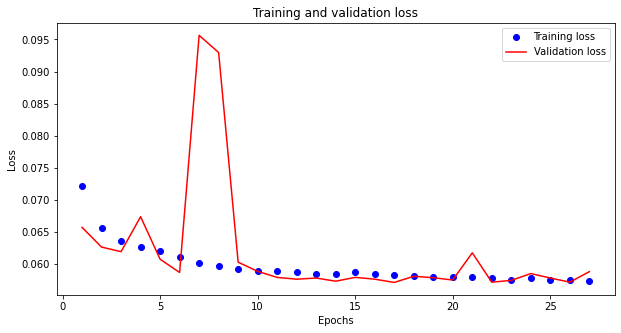

In [ ]:
#Plotting loss
train_loss_1 = history_1.history['loss']
val_loss_1 = history_1.history['val_loss']

plot_loss(train_loss_1,val_loss_1)

In [ ]:
#Predicting x_test
train_pred_1 = autoencoder_1.predict(noisy_x_train)
test_pred_1 = autoencoder_1.predict(noisy_x_test)

In [ ]:
#Training and Test mae
print('Train mae:',(round(mae_images(x_train, train_pred_1),5)))
print('Test mae:',(round(mae_images(x_test, test_pred_1), 5)))

Train mae: 0.05855
Test mae: 0.05884


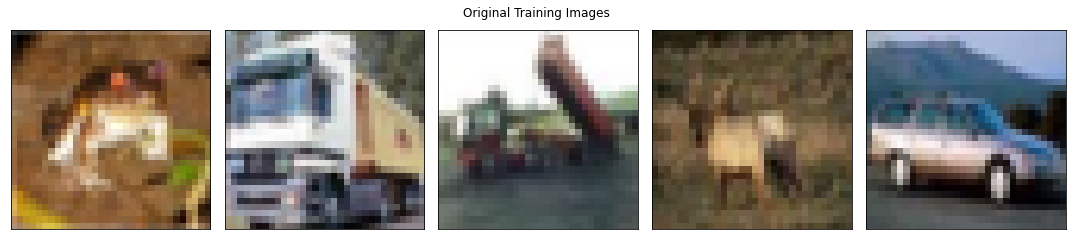

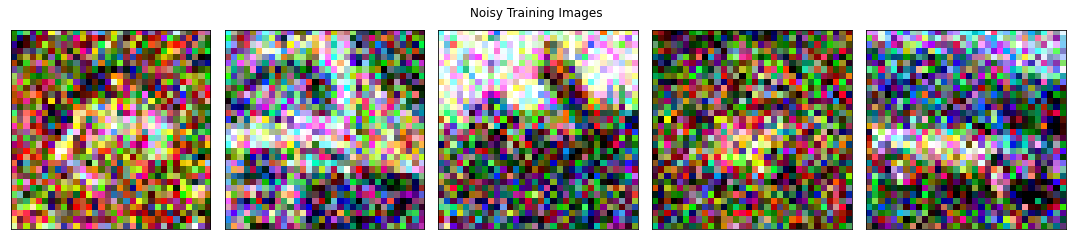

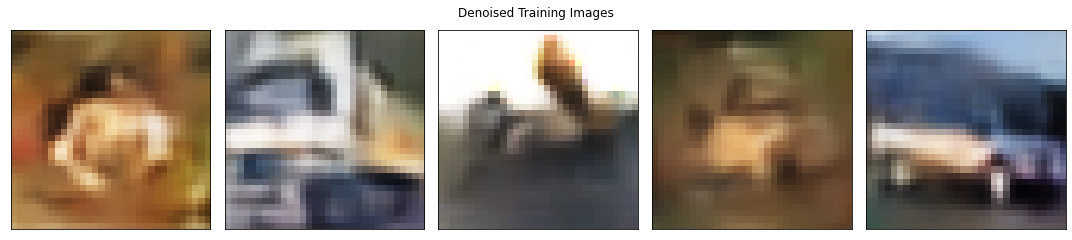

In [ ]:
#Plotting training set original and decoded images
image_plot(5,x_train,"Original Training Images")
image_plot(5,noisy_x_train,"Noisy Training Images")
image_plot(5,train_pred_1,"Denoised Training Images")

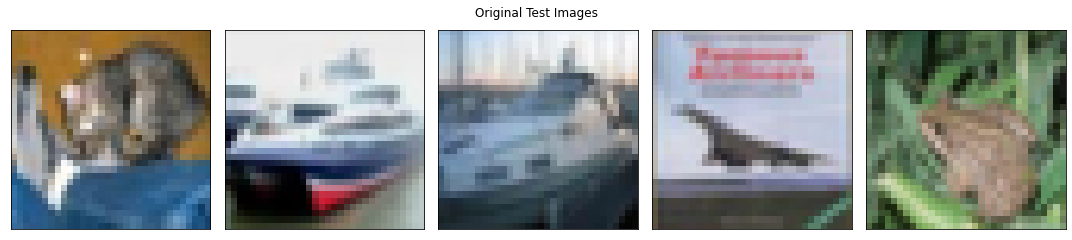

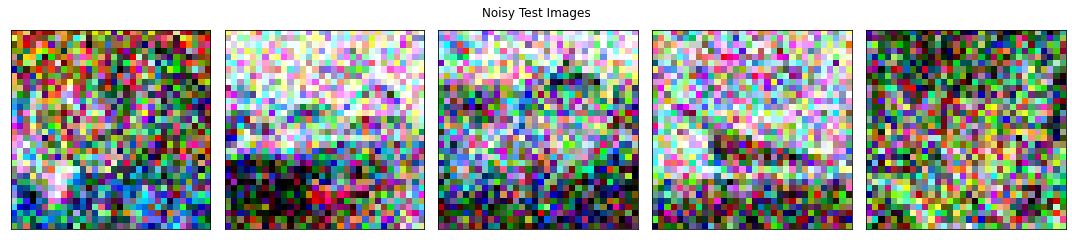

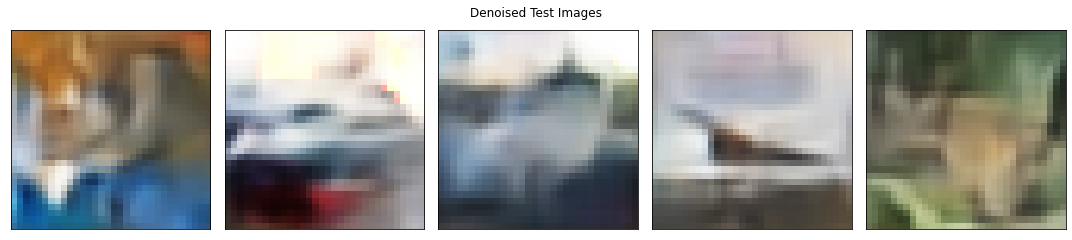

In [ ]:
#Plotting training set original and decoded images
image_plot(5,x_test,"Original Test Images")
image_plot(5,noisy_x_test,"Noisy Test Images")
image_plot(5,test_pred_1,"Denoised Test Images")

**Model 2**

In [ ]:
#Optimizer
optimizer_2 = optimizers.Adam(learning_rate=0.001)

#Compiling model
autoencoder_2.compile(optimizer=optimizer_2, loss='mae')

#Fitting model
history_2 = autoencoder_2.fit(noisy_x_train, x_train,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_split=0.3,
                callbacks=callback)

Epoch 1/100
1094/1094 [==============================] - 45s 12ms/step - loss: 0.0720 - val_loss: 0.0707
Epoch 2/100
1094/1094 [==============================] - 13s 12ms/step - loss: 0.0654 - val_loss: 0.0681
Epoch 3/100
1094/1094 [==============================] - 13s 12ms/step - loss: 0.0636 - val_loss: 0.0634
Epoch 4/100
1094/1094 [==============================] - 13s 12ms/step - loss: 0.0625 - val_loss: 0.0584
Epoch 5/100
1094/1094 [==============================] - 13s 12ms/step - loss: 0.0620 - val_loss: 0.0583
Epoch 6/100
1094/1094 [==============================] - 13s 12ms/step - loss: 0.0613 - val_loss: 0.0599
Epoch 7/100
1094/1094 [==============================] - 13s 12ms/step - loss: 0.0609 - val_loss: 0.0589
Epoch 8/100
1094/1094 [==============================] - 13s 12ms/step - loss: 0.0605 - val_loss: 0.0590
Epoch 9/100
1094/1094 [==============================] - 13s 12ms/step - loss: 0.0602 - val_loss: 0.0605
Epoch 10/100
1094/1094 [==============================]

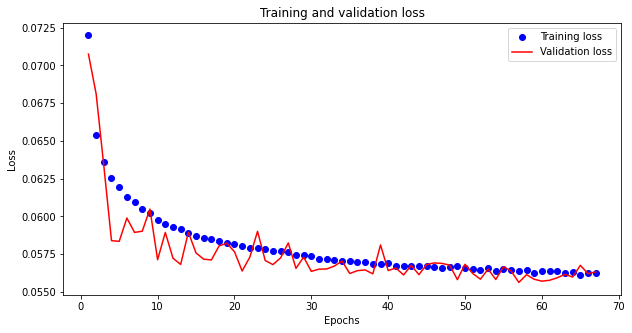

In [ ]:
#Plotting loss
train_loss_2 = history_2.history['loss']
val_loss_2 = history_2.history['val_loss']

plot_loss(train_loss_2,val_loss_2)


In [ ]:
#Predicting x_test
train_pred_2 = autoencoder_2.predict(noisy_x_train)
test_pred_2 = autoencoder_2.predict(noisy_x_test)

In [ ]:
#Training and Test mae
print('Train mae:',(round(mae_images(x_train, train_pred_2),5)))
print('Test mae:',(round(mae_images(x_test, test_pred_2), 5)))


Train mae: 0.05577
Test mae: 0.05636


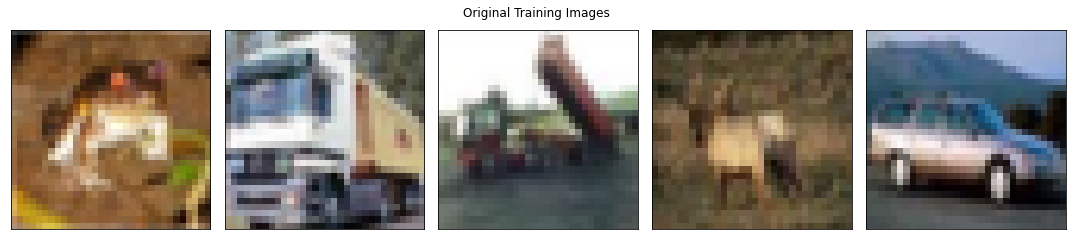

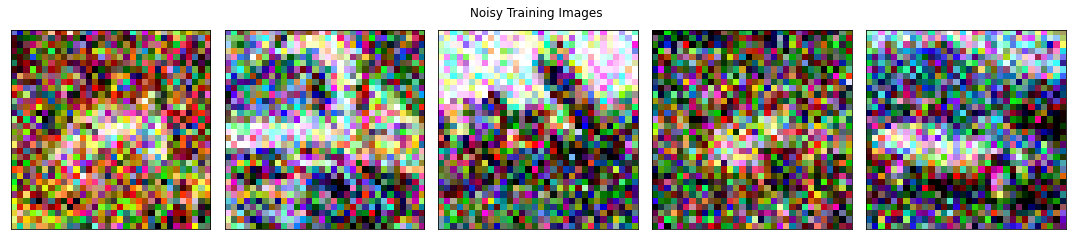

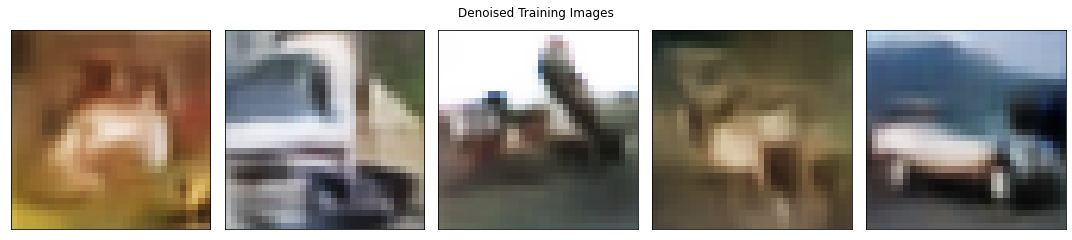

In [ ]:
#Plotting training set original and decoded images
image_plot(5,x_train,"Original Training Images")
image_plot(5,noisy_x_train,"Noisy Training Images")
image_plot(5,train_pred_2,"Denoised Training Images")

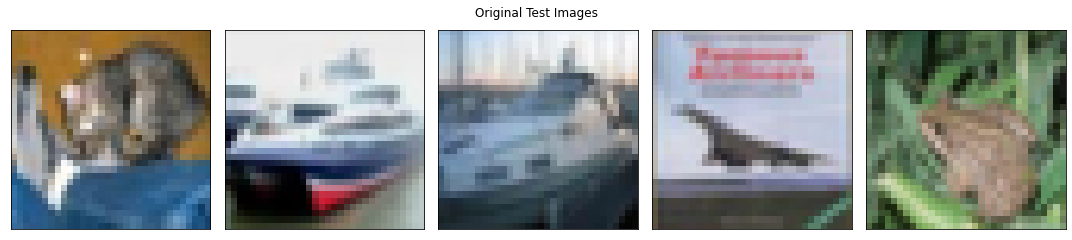

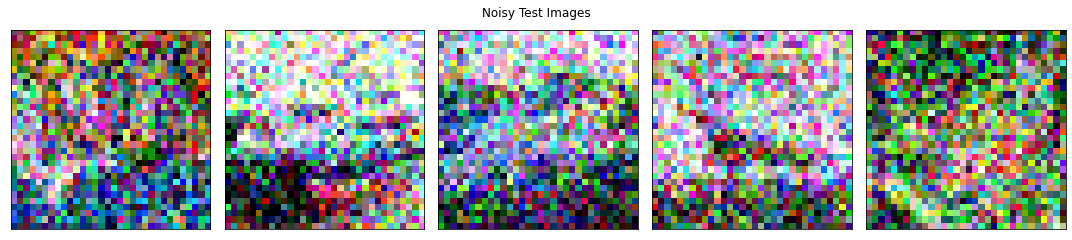

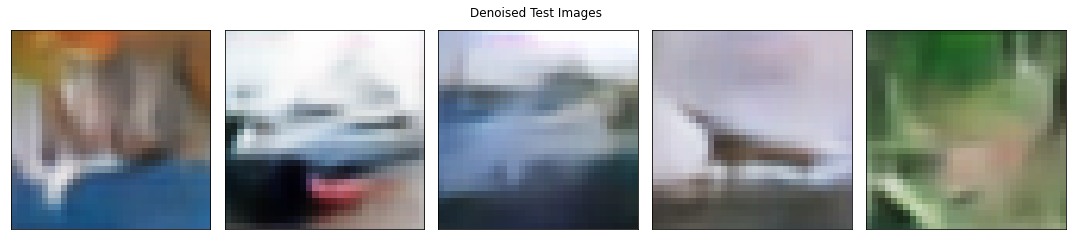

In [ ]:
#Plotting training set original and decoded images
image_plot(5,x_test,"Original Test Images")
image_plot(5,noisy_x_test,"Noisy Test Images")
image_plot(5,test_pred_2,"Denoised Test Images")

**Model 3**

In [ ]:
#Optimizer
optimizer_3 = optimizers.Adam(learning_rate=0.001)

#Compiling model
autoencoder_3.compile(optimizer=optimizer_3, loss='mae')

#Fitting model
history_3 = autoencoder_3.fit(noisy_x_train, x_train,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_split=0.3,
                callbacks=callback)

Epoch 1/100
1094/1094 [==============================] - 40s 8ms/step - loss: 0.0747 - val_loss: 0.0668
Epoch 2/100
1094/1094 [==============================] - 8s 8ms/step - loss: 0.0674 - val_loss: 0.0655
Epoch 3/100
1094/1094 [==============================] - 8s 8ms/step - loss: 0.0658 - val_loss: 0.0626
Epoch 4/100
1094/1094 [==============================] - 8s 8ms/step - loss: 0.0650 - val_loss: 0.0623
Epoch 5/100
1094/1094 [==============================] - 8s 8ms/step - loss: 0.0641 - val_loss: 0.0625
Epoch 6/100
1094/1094 [==============================] - 8s 8ms/step - loss: 0.0638 - val_loss: 0.0625
Epoch 7/100
1094/1094 [==============================] - 8s 8ms/step - loss: 0.0631 - val_loss: 0.0621
Epoch 8/100
1094/1094 [==============================] - 8s 8ms/step - loss: 0.0628 - val_loss: 0.0609
Epoch 9/100
1094/1094 [==============================] - 8s 8ms/step - loss: 0.0623 - val_loss: 0.0601
Epoch 10/100
1094/1094 [==============================] - 8s 8ms/step - 

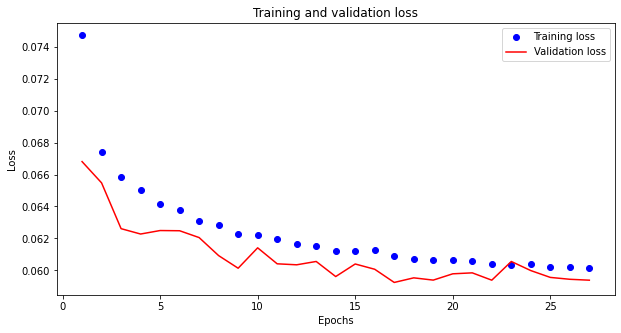

In [ ]:
#Plotting loss
train_loss_3 = history_3.history['loss']
val_loss_3 = history_3.history['val_loss']

plot_loss(train_loss_3,val_loss_3)

In [ ]:
#Predicting x_test
train_pred_3 = autoencoder_3.predict(noisy_x_train)
test_pred_3 = autoencoder_3.predict(noisy_x_test)

In [ ]:
#Training and Test mae
print('Train mae:',(round(mae_images(x_train, train_pred_3),5)))
print('Test mae:',(round(mae_images(x_test, test_pred_3), 5)))

Train mae: 0.05933
Test mae: 0.05942


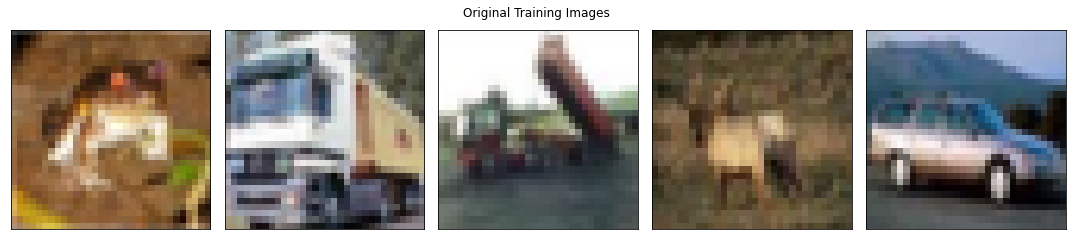

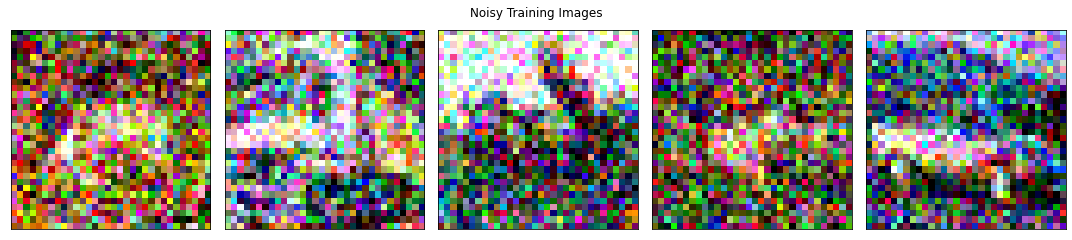

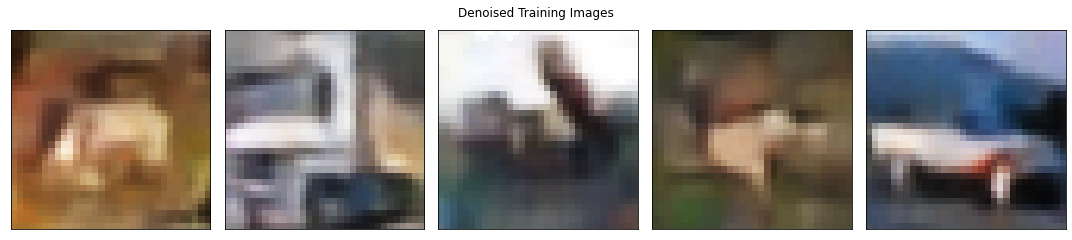

In [ ]:
#Plotting training set original and decoded images
image_plot(5,x_train,"Original Training Images")
image_plot(5,noisy_x_train,"Noisy Training Images")
image_plot(5,train_pred_3,"Denoised Training Images")

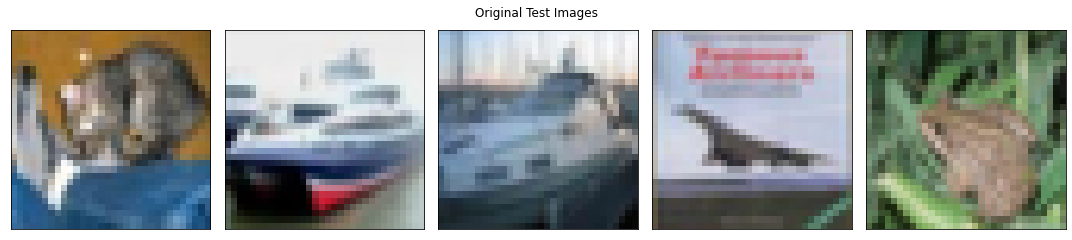

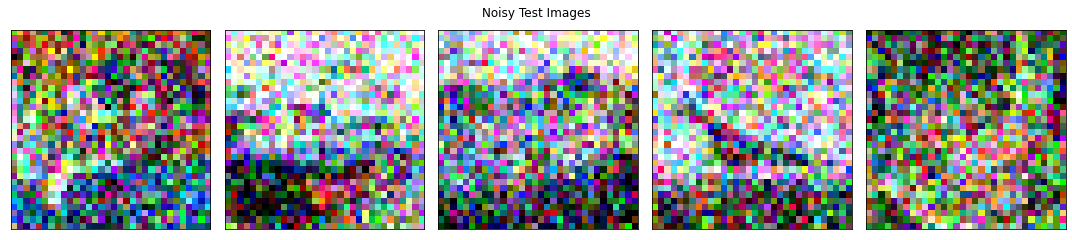

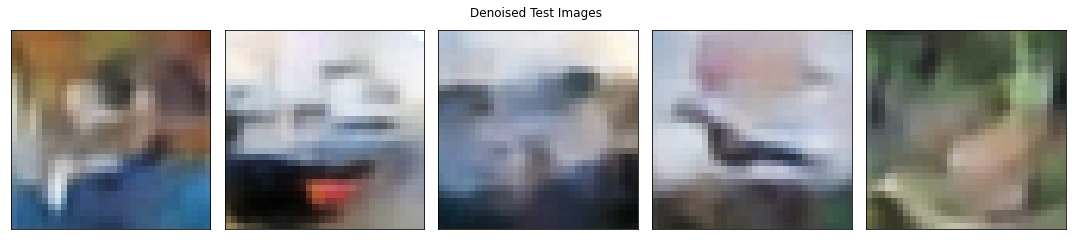

In [ ]:
#Plotting training set original and decoded images
image_plot(5,x_test,"Original Test Images")
image_plot(5,noisy_x_test,"Noisy Test Images")
image_plot(5,test_pred_3,"Denoised Test Images")

**Model 4**

In [ ]:
#Optimizer
optimizer_4 = optimizers.Nadam(learning_rate=0.001)

#Compiling model
autoencoder_4.compile(optimizer=optimizer_4, loss='mae')

#Fitting model
history_4 = autoencoder_4.fit(noisy_x_train, x_train,
                epochs=100,
                batch_size=64,
                shuffle=True,
                validation_split=0.3,
                callbacks=callback)

Epoch 1/100
547/547 [==============================] - 39s 13ms/step - loss: 0.0753 - val_loss: 0.0687
Epoch 2/100
547/547 [==============================] - 6s 11ms/step - loss: 0.0659 - val_loss: 0.0631
Epoch 3/100
547/547 [==============================] - 6s 11ms/step - loss: 0.0645 - val_loss: 0.0641
Epoch 4/100
547/547 [==============================] - 6s 11ms/step - loss: 0.0633 - val_loss: 0.0610
Epoch 5/100
547/547 [==============================] - 6s 11ms/step - loss: 0.0627 - val_loss: 0.0609
Epoch 6/100
547/547 [==============================] - 6s 11ms/step - loss: 0.0621 - val_loss: 0.0616
Epoch 7/100
547/547 [==============================] - 6s 11ms/step - loss: 0.0618 - val_loss: 0.0615
Epoch 8/100
547/547 [==============================] - 6s 11ms/step - loss: 0.0615 - val_loss: 0.0598
Epoch 9/100
547/547 [==============================] - 6s 11ms/step - loss: 0.0613 - val_loss: 0.0594
Epoch 10/100
547/547 [==============================] - 6s 11ms/step - loss: 0.06

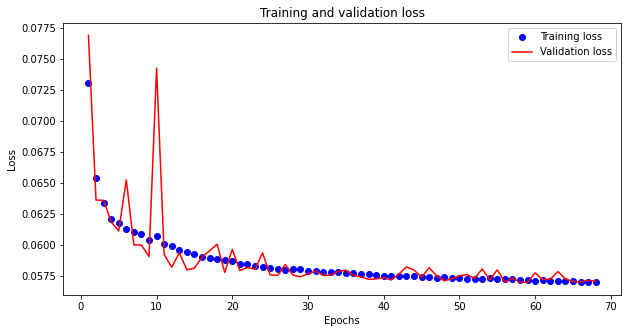

In [ ]:
#Plotting loss
train_loss_4 = history_4.history['loss']
val_loss_4 = history_4.history['val_loss']

plot_loss(train_loss_4,val_loss_4)

In [ ]:
#Predicting x_test
train_pred_4 = autoencoder_4.predict(noisy_x_train)
test_pred_4 = autoencoder_4.predict(noisy_x_test)

In [ ]:
#Training and Test mae
print('Train mae:',(round(mae_images(x_train, train_pred_4),5)))
print('Test mae:',(round(mae_images(x_test, test_pred_4), 5)))

Train mae: 0.05777
Test mae: 0.05795


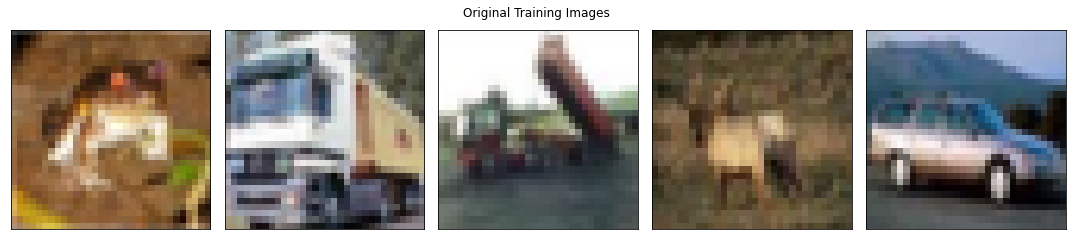

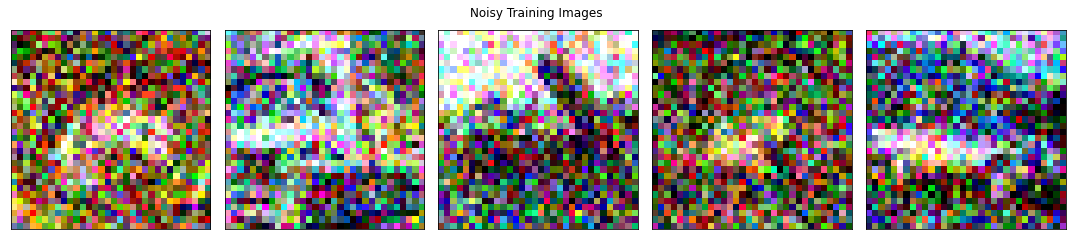

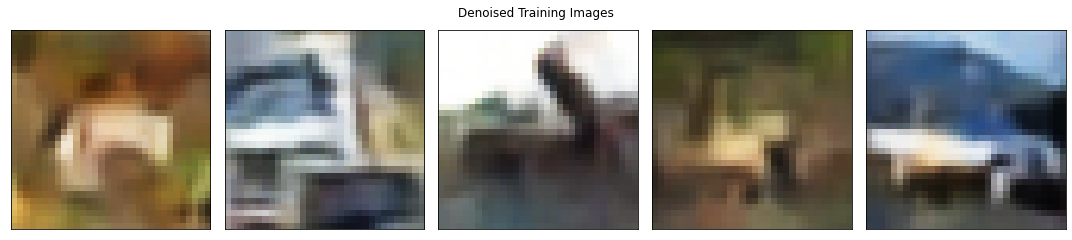

In [ ]:
#Plotting training set original and decoded images
image_plot(5,x_train,"Original Training Images")
image_plot(5,noisy_x_train,"Noisy Training Images")
image_plot(5,train_pred_4,"Denoised Training Images")

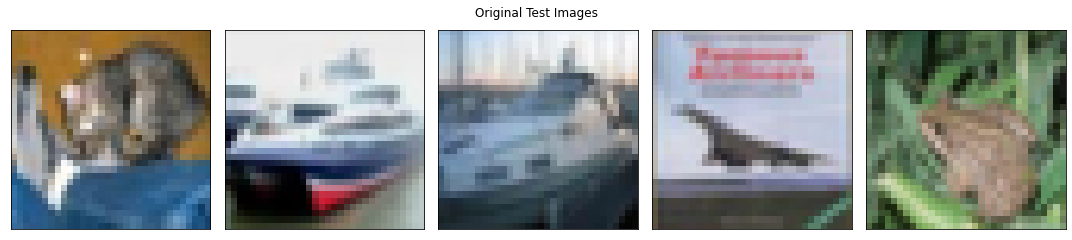

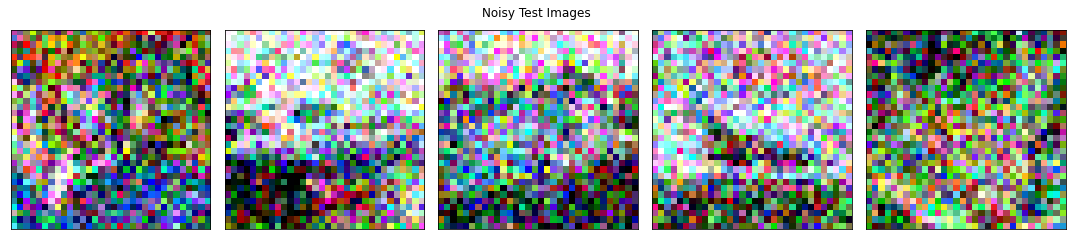

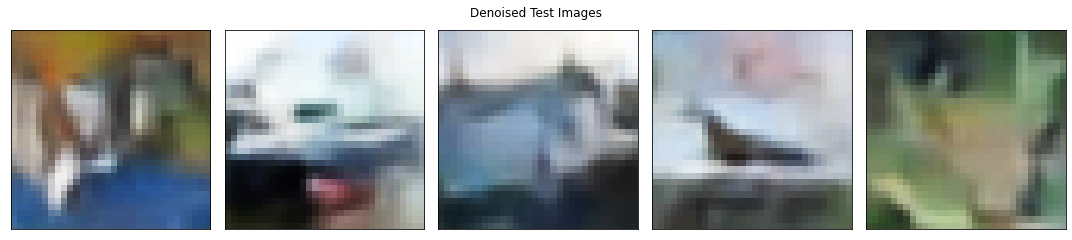

In [ ]:
#Plotting training set original and decoded images
image_plot(5,x_test,"Original Test Images")
image_plot(5,noisy_x_test,"Noisy Test Images")
image_plot(5,test_pred_4,"Denoised Test Images")

**Model 5**

In [10]:
#Optimizer
optimizer_5 = optimizers.Nadam(learning_rate=0.001)

#Compiling model
autoencoder_5.compile(optimizer=optimizer_5, loss='mae')

#Fitting model
history_5 = autoencoder_5.fit(noisy_x_train, x_train,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_split=0.3,
                callbacks=callback)

Epoch 1/100
1094/1094 [==============================] - 45s 12ms/step - loss: 0.0678 - val_loss: 0.0614
Epoch 2/100
1094/1094 [==============================] - 12s 11ms/step - loss: 0.0624 - val_loss: 0.0613
Epoch 3/100
1094/1094 [==============================] - 12s 11ms/step - loss: 0.0609 - val_loss: 0.0630
Epoch 4/100
1094/1094 [==============================] - 12s 11ms/step - loss: 0.0595 - val_loss: 0.0583
Epoch 5/100
1094/1094 [==============================] - 13s 11ms/step - loss: 0.0587 - val_loss: 0.0602
Epoch 6/100
1094/1094 [==============================] - 13s 11ms/step - loss: 0.0578 - val_loss: 0.0581
Epoch 7/100
1094/1094 [==============================] - 13s 11ms/step - loss: 0.0575 - val_loss: 0.0587
Epoch 8/100
1094/1094 [==============================] - 12s 11ms/step - loss: 0.0571 - val_loss: 0.0563
Epoch 9/100
1094/1094 [==============================] - 12s 11ms/step - loss: 0.0569 - val_loss: 0.0561
Epoch 10/100
1094/1094 [==============================]

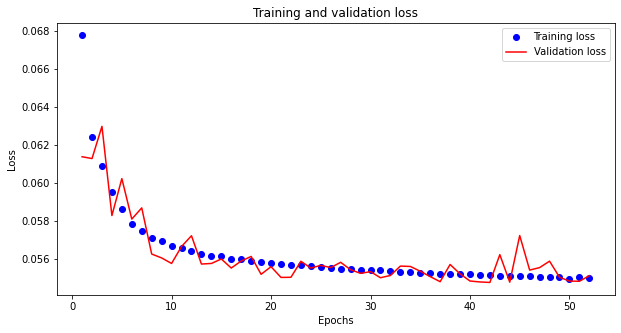

In [11]:
#Plotting loss
train_loss_5 = history_5.history['loss']
val_loss_5 = history_5.history['val_loss']

plot_loss(train_loss_5,val_loss_5)

In [12]:
#Predicting x_test
train_pred_5 = autoencoder_5.predict(noisy_x_train)
test_pred_5 = autoencoder_5.predict(noisy_x_test)

In [13]:
#Training and Test mae
print('Train mae:',(round(mae_images(x_train, train_pred_5),5)))
print('Test mae:',(round(mae_images(x_test, test_pred_5), 5)))

Train mae: 0.05495
Test mae: 0.0552


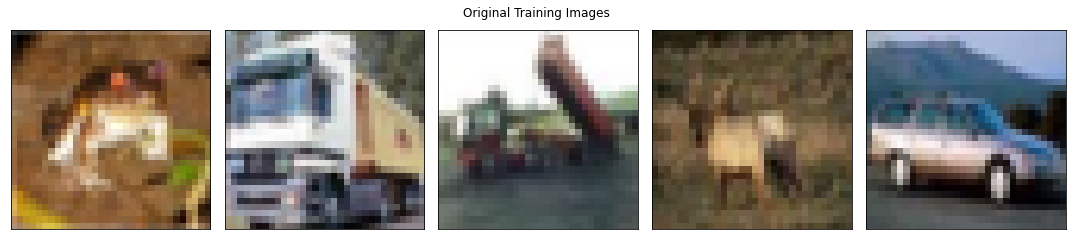

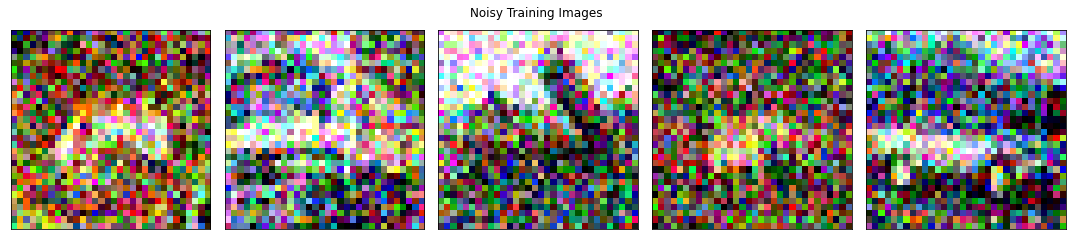

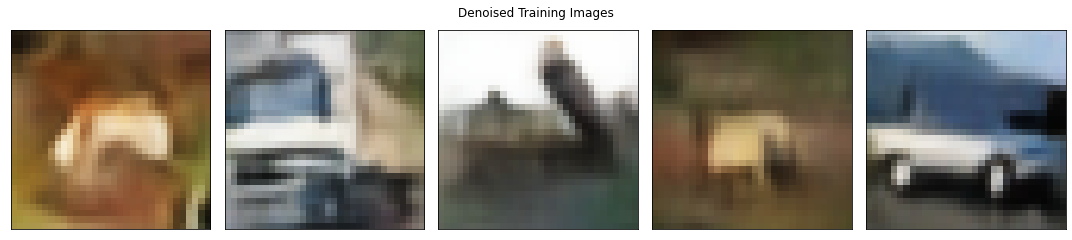

In [14]:
#Plotting training set original and decoded images
image_plot(5,x_train,"Original Training Images")
image_plot(5,noisy_x_train,"Noisy Training Images")
image_plot(5,train_pred_5,"Denoised Training Images")

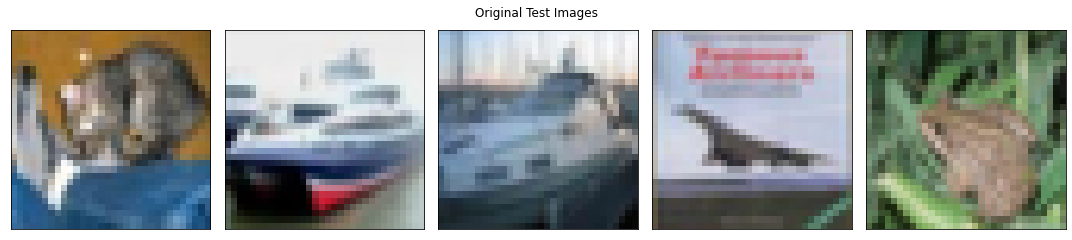

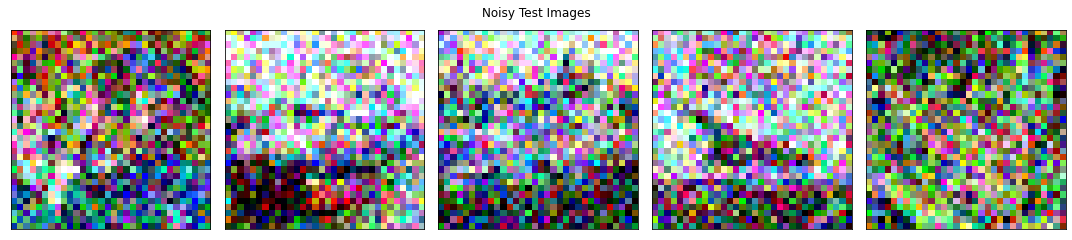

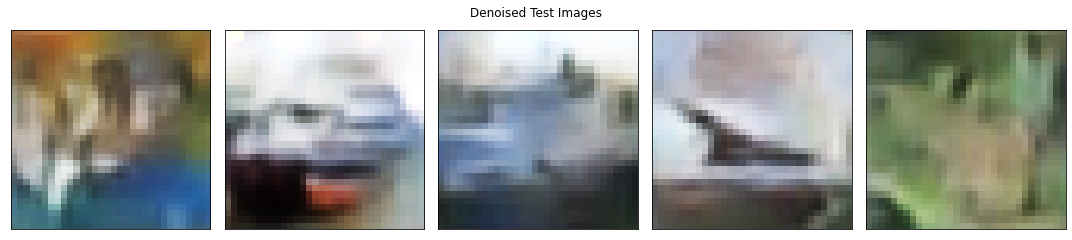

In [ ]:
#Plotting training set original and decoded images
image_plot(5,x_test,"Original Test Images")
image_plot(5,noisy_x_test,"Noisy Test Images")
image_plot(5,test_pred_5,"Denoised Test Images")

<a id = "cell_report"></a>
## 5. Experiments Report

In [31]:
experiment_sumary = pd.DataFrame({'Train MAE': [0.05855,0.05577,0.05933,0.05777,0.05495],
                                  'Valid MAE':[0.05884,0.05636,0.05942,0.05795,0.0552],
                                  '#Trainable parameters':[192387,303171,50115,58467,125507],
                                  'Activation':['ReLU','LeakyReLU','ReLU','ReLU','ReLU'],
                                  'Optimizer':['Nadam','Nadam','Adam','Nadam','Nadam']})
experiment_sumary

,Train MAE,Valid MAE,#Trainable parameters,Activation,Optimizer
0,0.05855,0.05884,192387,ReLU,Nadam
1,0.05577,0.05636,303171,LeakyReLU,Nadam
2,0.05933,0.05942,50115,ReLU,Adam
3,0.05777,0.05795,58467,ReLU,Nadam
4,0.05495,0.05520,125507,ReLU,Nadam


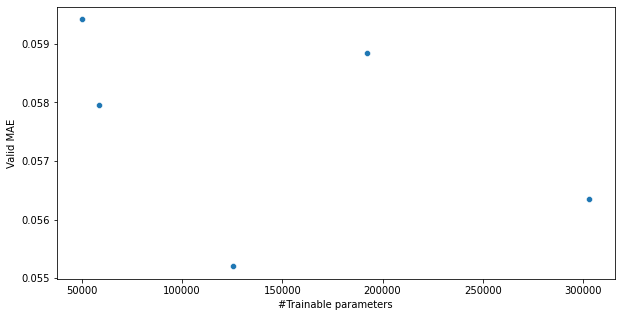

In [46]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=experiment_sumary['#Trainable parameters'],y=experiment_sumary['Valid MAE'])
plt.show()

Due to limited GPU availability on colab, all models could not be run in single runtime. Hence, experiments report details has been filled manually instead passing the variables.

Model architecture was focused more in experiments. As per previous multiple short runs, Nadam and Adam optimizers were selected along with ReLU and LeakyReLU as activation function. Thus, hyper parameters are mostly common except for the model architecture.

Model 1 had 192387 parameters with activation ReLU, optimizer Nadam, and two hidden layers in enocder and decoder each. In Model 2, strength of Model 1 was increased to 303171 by increasing neurons in decoder and changing activation to LeakyReLU. It has been observed, that LeakyReLU considerably reduces number of parameters as compared to ReLU. In Model 3, strength of Model 1 was reduced by reducing parameters to 50115 and changing optimizer to Adam. In Model 4, Model 3 Upsampling layer was changed to Conv2DTranspose with 2 strides which adds convoluation and upsampling instead of just upsampling. This increased number parameters slightly in Model 4 as compared to Model 3. In Model 5, two layers were added in convolution with max pooling and encoded with convlution. Decoder contained one covulation layer followed by upsampling and two convulation layers without upsampling. This model provided 125507 number of parameters and was the best model w.r.t. MAE of 0.05495 and 0.05520 on training and test dataset
<br>